In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal  # 频域分析
from scipy.spatial.transform import Rotation  # 四元数转欧拉角
import plotly.express as px  # 交互式可视化

In [30]:
df = pd.read_csv('output.csv')
df = df.iloc[2:].reset_index(drop=True)

In [31]:
# 处理时间戳（单位为毫秒）
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [32]:
# 将四元数转换为欧拉角（弧度）
def quaternion_to_euler(x, y, z, w):
    rotation = Rotation.from_quat([x, y, z, w])
    return rotation.as_euler('xyz')  # 返回 roll, pitch, yaw


# 为原始和滤波数据添加欧拉角列
df[['imu_roll', 'imu_pitch', 'imu_yaw']] = df.apply(
    lambda row: quaternion_to_euler(row['imu_quaternion_x'], row['imu_quaternion_y'],
                                    row['imu_quaternion_z'], row['imu_quaternion_w']), axis=1, result_type='expand'
)

df[['kf_roll', 'kf_pitch', 'kf_yaw']] = df.apply(
    lambda row: quaternion_to_euler(row['kf_quaternion_x'], row['kf_quaternion_y'],
                                    row['kf_quaternion_z'], row['kf_quaternion_w']), axis=1, result_type='expand'
)

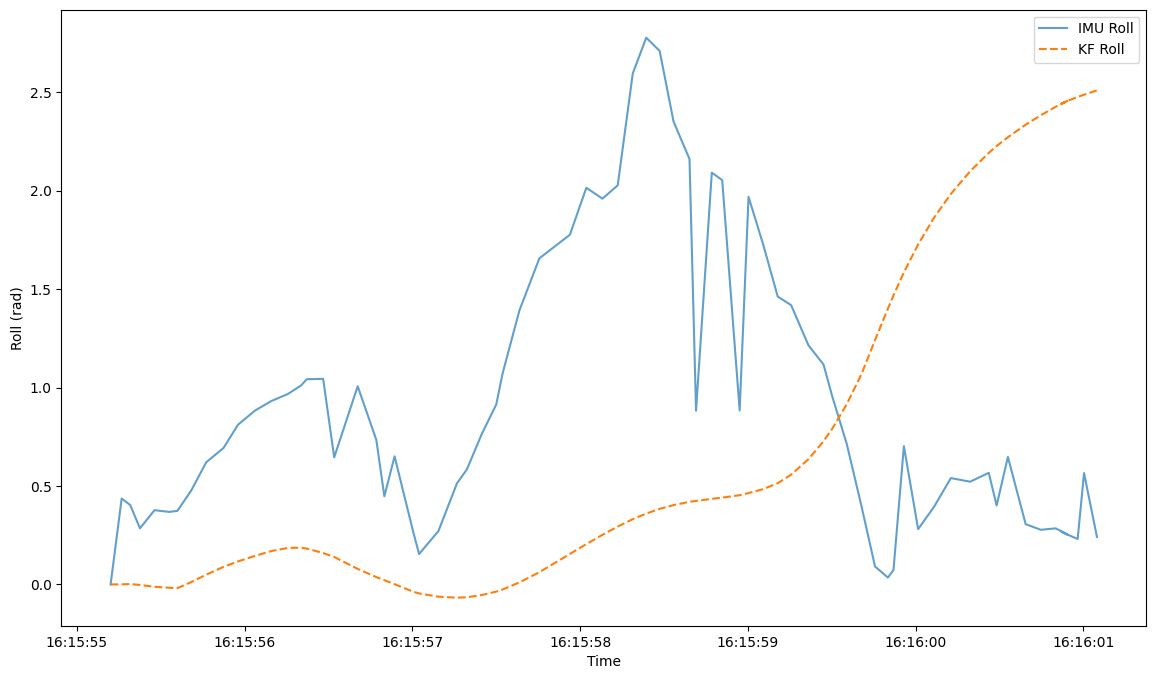

In [33]:
# 可视化姿态角对比
plt.figure(figsize=(14, 8))
plt.plot(df['timestamp'], df['imu_roll'], label='IMU Roll', alpha=0.7)
plt.plot(df['timestamp'], df['kf_roll'], label='KF Roll', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Roll (rad)')
plt.legend()
plt.show()

In [34]:
# 计算加速度统计量
acc_stats = df[[
    'imu_acceleration_x', 'imu_acceleration_y', 'imu_acceleration_z',
    'kf_acceleration_x', 'kf_acceleration_y', 'kf_acceleration_z'
]].agg(['mean', 'std', 'min', 'max'])

print("加速度统计量:\n", acc_stats)

加速度统计量:
       imu_acceleration_x  imu_acceleration_y  imu_acceleration_z  \
mean           -0.050407           -0.494309            0.026829   
std             1.869004            1.177682            2.313399   
min            -7.800000           -5.300000           -8.700000   
max             5.000000            1.600000            5.900000   

      kf_acceleration_x  kf_acceleration_y  kf_acceleration_z  
mean          -0.065302          -0.370959           0.133835  
std            0.150786           0.265473           0.245780  
min           -0.337471          -0.738771          -1.181829  
max            0.363640           0.085581           0.592570  


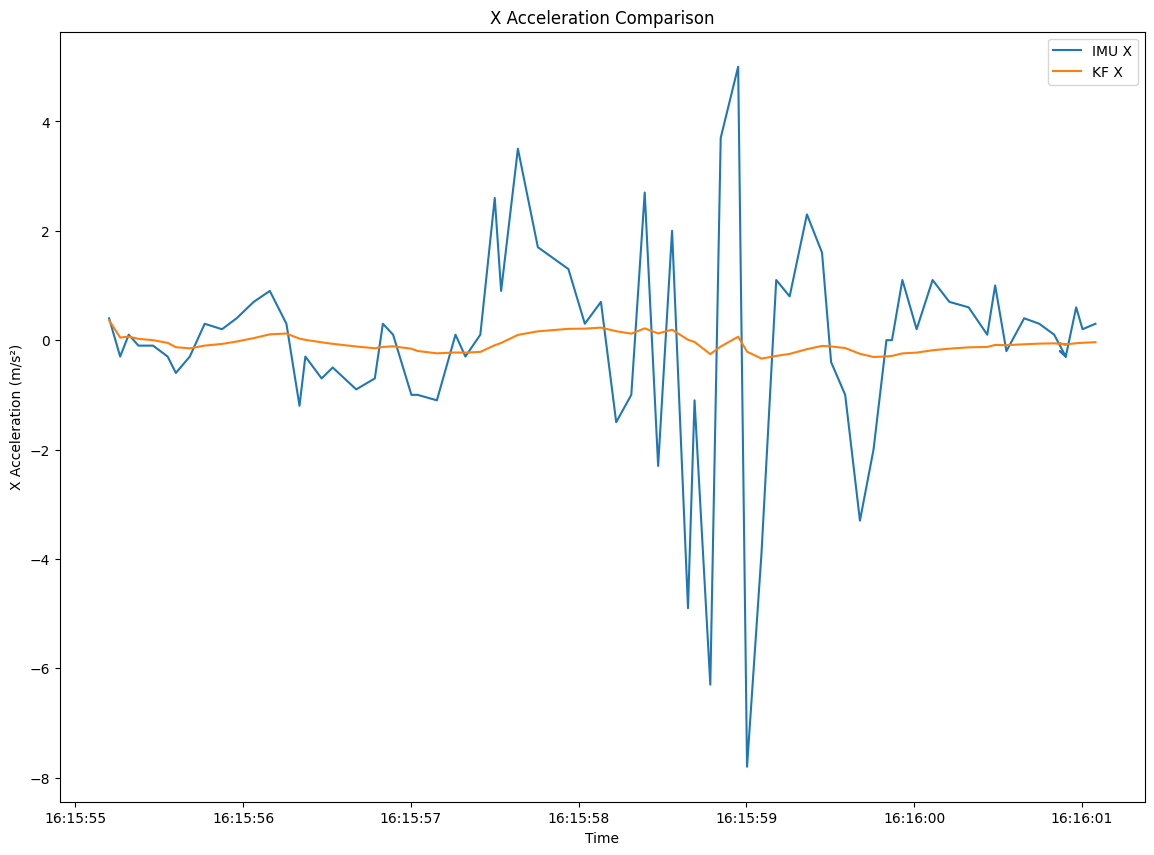

In [35]:
# 绘制 X 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_x'], label='IMU X')
plt.plot(df['timestamp'], df['kf_acceleration_x'], label='KF X')
plt.xlabel('Time')
plt.ylabel('X Acceleration (m/s²)')
plt.legend()
plt.title('X Acceleration Comparison')
plt.show()

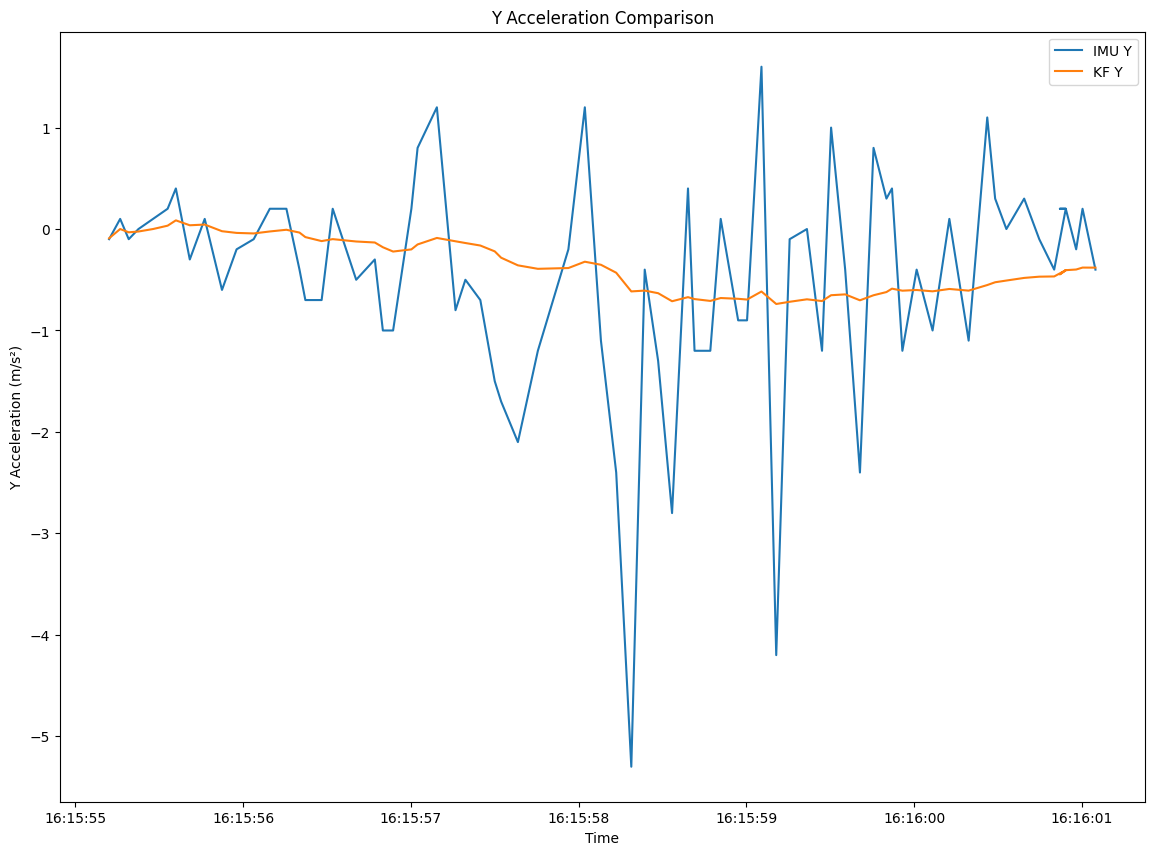

In [36]:
# 绘制 Y 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_y'], label='IMU Y')
plt.plot(df['timestamp'], df['kf_acceleration_y'], label='KF Y')
plt.xlabel('Time')
plt.ylabel('Y Acceleration (m/s²)')
plt.legend()
plt.title('Y Acceleration Comparison')
plt.show()

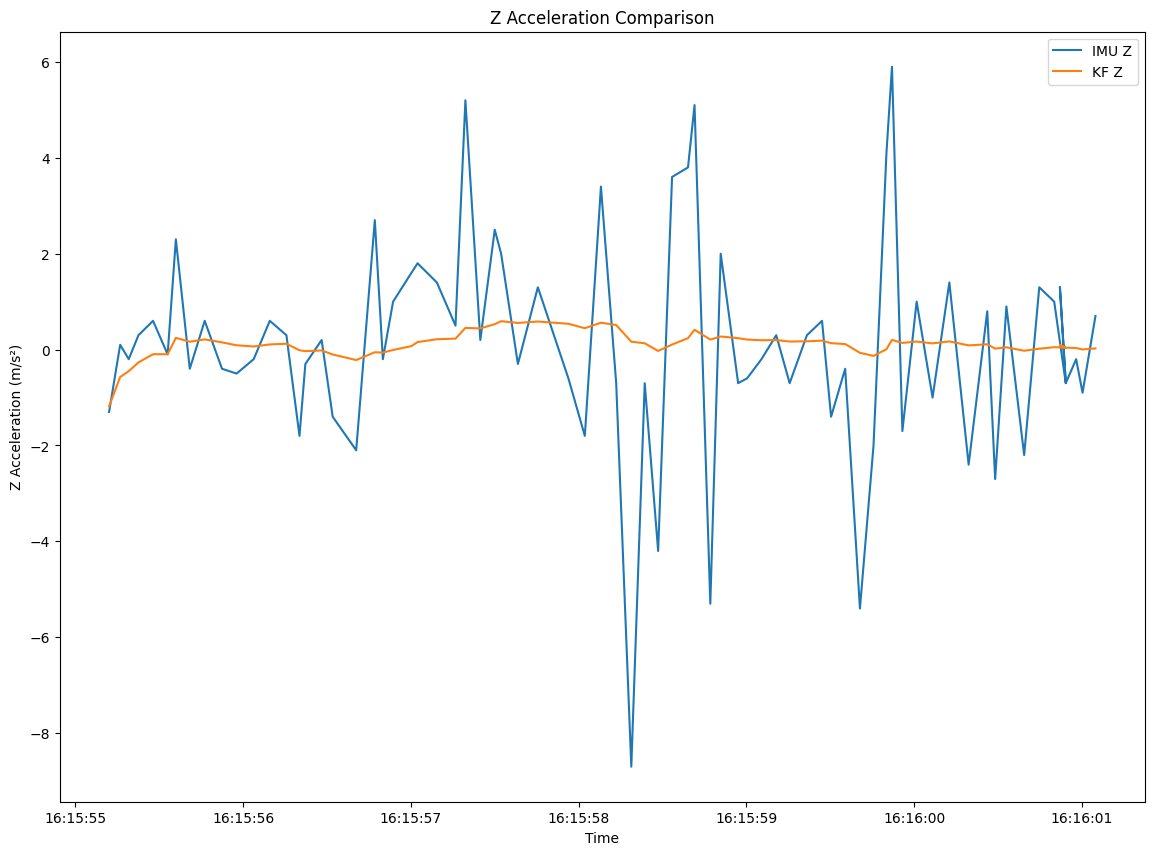

In [37]:
# 绘制 Z 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_z'], label='IMU Z')
plt.plot(df['timestamp'], df['kf_acceleration_z'], label='KF Z')
plt.xlabel('Time')
plt.ylabel('Z Acceleration (m/s²)')
plt.legend()
plt.title('Z Acceleration Comparison')
plt.show()

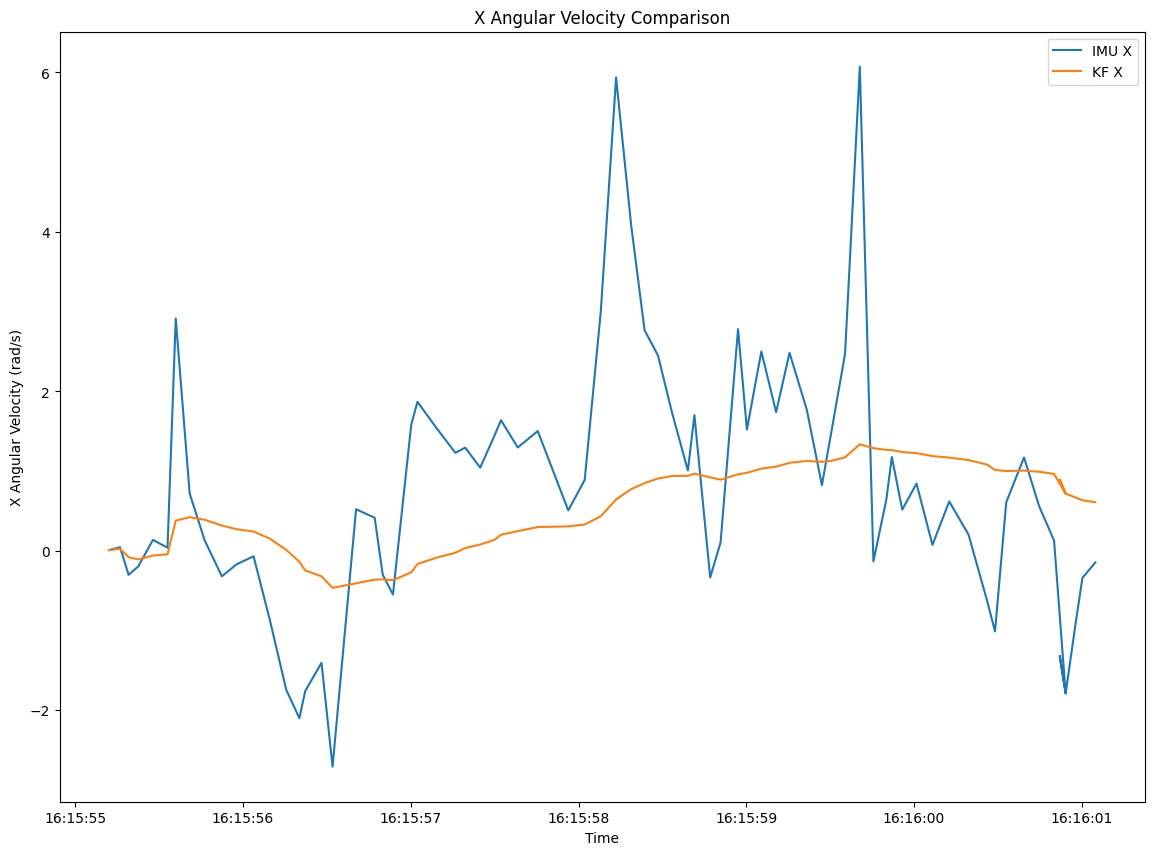

In [38]:
# 绘制 X 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_x'], label='IMU X')
plt.plot(df['timestamp'], df['kf_angular_velocity_x'], label='KF X')
plt.xlabel('Time')
plt.ylabel('X Angular Velocity (rad/s)')
plt.legend()
plt.title('X Angular Velocity Comparison')
plt.show()

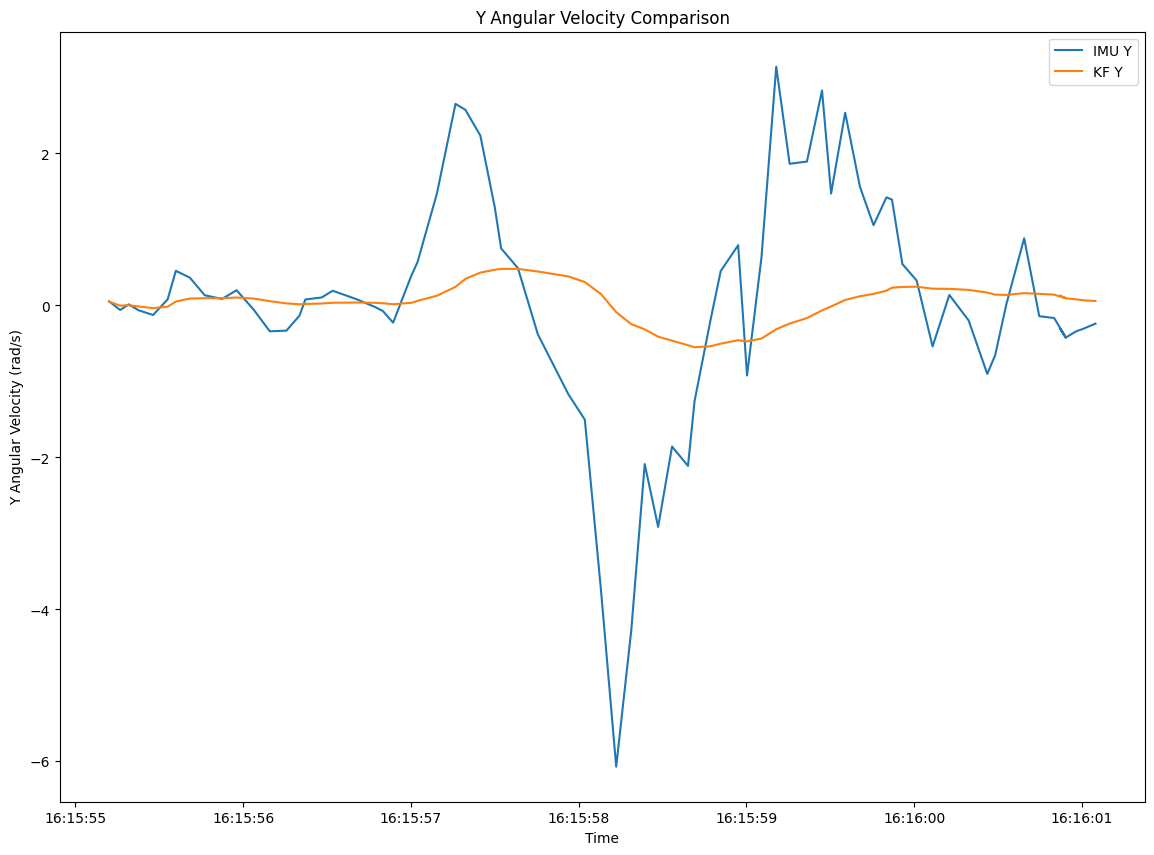

In [39]:
# 绘制 Y 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_y'], label='IMU Y')
plt.plot(df['timestamp'], df['kf_angular_velocity_y'], label='KF Y')
plt.xlabel('Time')
plt.ylabel('Y Angular Velocity (rad/s)')
plt.legend()
plt.title('Y Angular Velocity Comparison')
plt.show()

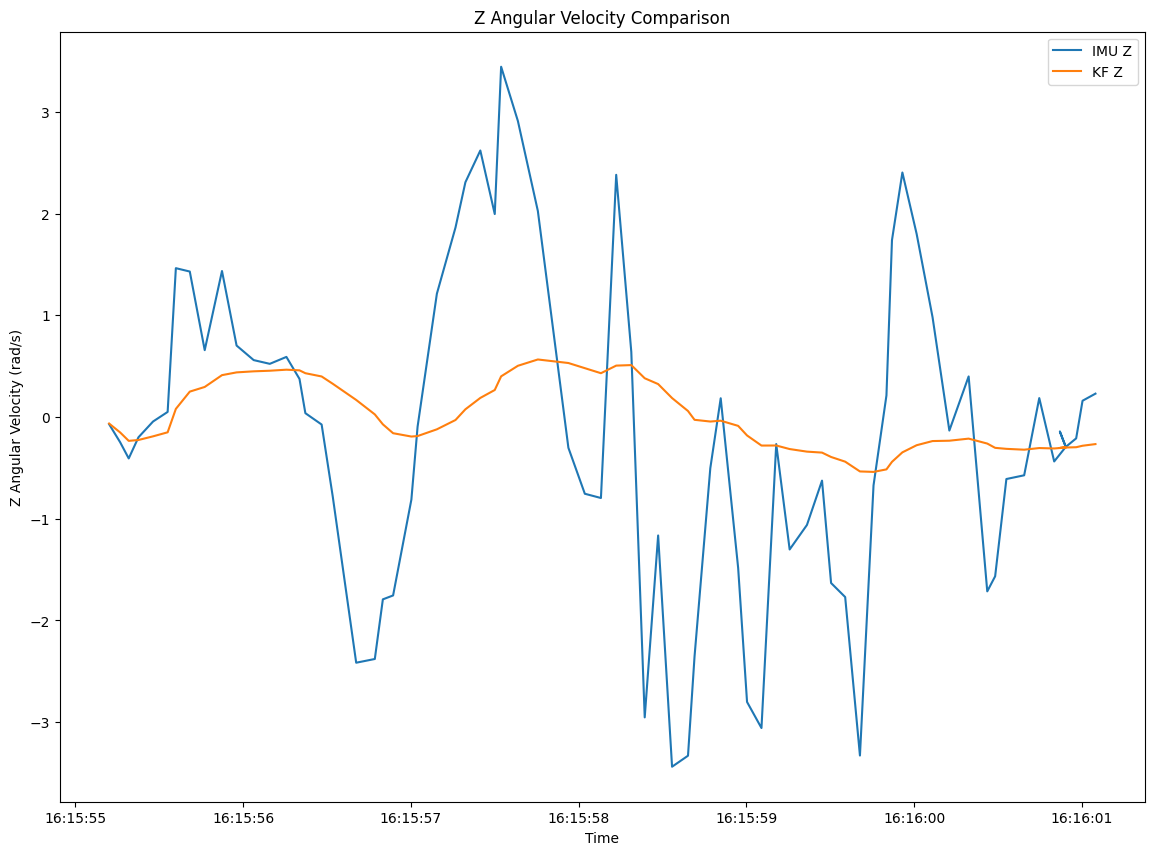

In [40]:
# 绘制 Z 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_z'], label='IMU Z')
plt.plot(df['timestamp'], df['kf_angular_velocity_z'], label='KF Z')
plt.xlabel('Time')
plt.ylabel('Z Angular Velocity (rad/s)')
plt.legend()
plt.title('Z Angular Velocity Comparison')
plt.show()

In [41]:
# 计算加速度和角速度的方差
variance_imu_acc = df[['imu_acceleration_x', 'imu_acceleration_y', 'imu_acceleration_z']].var()
variance_kf_acc = df[['kf_acceleration_x', 'kf_acceleration_y', 'kf_acceleration_z']].var()

variance_imu_gyro = df[['imu_angular_velocity_x', 'imu_angular_velocity_y', 'imu_angular_velocity_z']].var()
variance_kf_gyro = df[['kf_angular_velocity_x', 'kf_angular_velocity_y', 'kf_angular_velocity_z']].var()

# 将结果合并为一个 DataFrame
variance_acc = pd.DataFrame({
    'IMU': variance_imu_acc.values,  # 只取数值部分
    'KF': variance_kf_acc.values,
    'Reduction (%)': (1 - variance_kf_acc.values / variance_imu_acc.values) * 100
}, index=['acceleration_x', 'acceleration_y', 'acceleration_z'])

variance_gyro = pd.DataFrame({
    'IMU': variance_imu_gyro.values,
    'KF': variance_kf_gyro.values,
    'Reduction (%)': (1 - variance_kf_gyro.values / variance_imu_gyro.values) * 100
}, index=['angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'])


print("加速度方差（原始 vs 滤波后）:")
print(variance_acc)

print("\n角速度方差（原始 vs 滤波后）:")
print(variance_gyro)

加速度方差（原始 vs 滤波后）:
                     IMU        KF  Reduction (%)
acceleration_x  3.493176  0.022736      99.349123
acceleration_y  1.386935  0.070476      94.918587
acceleration_z  5.351815  0.060408      98.871268

角速度方差（原始 vs 滤波后）:
                         IMU        KF  Reduction (%)
angular_velocity_x  2.649047  0.284860      89.246719
angular_velocity_y  2.500969  0.064908      97.404670
angular_velocity_z  2.591183  0.113023      95.638167
